## TFIDF with preprocessing on Logistic MultiClass Classifier

In [1]:
import nltk
import nltk.sentiment
import numpy as np
import json
import pickle
import timeit
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import re

In [2]:
f = open("../stopwords_list.dat")
stopwords = set([word.strip().lower() for word in f.readlines()])
f.close()

In [3]:
devfile = "../../A1_Data/dev.json"
trainfile = "../../A1_Data/train.json"

### Train Model

In [4]:
feature_vector = pickle.load(open("neg_tfidf_train_vector.pickle","rb"))

In [5]:
train_labels = []
f = open(trainfile,"r")
while(True):
    s = f.readline()
    if (s==""):
        break
    json_dump = json.loads(s)    
    train_labels.append(json_dump["ratings"])
f.close()

In [6]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="l2", multi_class='multinomial', solver="saga", max_iter=2000)

In [8]:
start = timeit.default_timer()
print(model.fit(feature_vector, train_labels))
print("Train time:",timeit.default_timer()-start)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)
Train time: 213.91886883499956


In [9]:
pickle.dump(model,open("neg_logist_model.pickle", "wb"))

### Validation phase

In [10]:
dev_feature_vector = pickle.load(open("neg_tfidf_dev_vector.pickle","rb"))

In [11]:
dev_labels = []
dev_data = []
f = open(devfile,"r")
while(True):
    s = f.readline()
    if (s==""):
        break
    json_dump = json.loads(s)    
    dev_labels.append(json_dump["ratings"])
    dev_data.append(json_dump["review"])
f.close()

In [12]:
conf_mat = np.zeros((5,5), dtype=int)
f = open("error_file","w")
for i in range(0,len(dev_labels),1000):
    fv = dev_feature_vector[i:i+1000]
    y_pred = model.predict(fv)
    conf_mat+= confusion_matrix(y_pred, dev_labels[i:i+1000])
    
    for p in range(1000):
        if  abs(y_pred[p]-dev_labels[i+p])>2:
            f.write("Gold: %.1f, Predicted: %.1f, Review: %s\n"%(dev_labels[i+p], y_pred[p], dev_data[i+p].replace('\n','\\n')))
print("Confusion Matrix")
print(conf_mat)

Confusion Matrix
[[25430  5114  1477   436   551]
 [ 2770  5962  2686   362   120]
 [  698  3642  9630  3478   554]
 [  257   893  6601 22784  9802]
 [  634   528  1722 16946 76923]]


In [13]:
print("Accuracy: ",conf_mat.trace()/len(dev_data))
score = 0
for i in range(5):
    for j in range(5):
        score+=conf_mat[i][j]*((i-j)**2)
print("Cost: ",score)

Accuracy:  0.703645
Cost:  104892


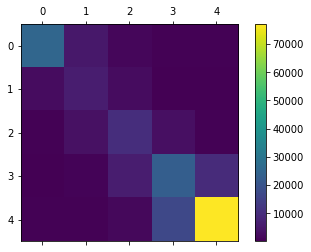

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat)
fig.colorbar(cax)
plt.savefig("conf_mat.jpg")
plt.close()